# Using *mdx2* in python (advanced)

### Imports

In [4]:
# for loading mdx2 objects in python
from mdx2.utils import loadobj

# for calculating statistics
import numpy as np
import pandas as pd

## Intensity statistics

### Intensity vs. resolution

Load the corrected, unmerged data

In [5]:
# load table as mdx2 object
tab = loadobj('corrected.nxs','hkl_table')

# convert to pandas DataFrame
df = tab.to_frame().set_index(['h','k','l','op','n']).sort_index()

# show the first several rows
df.head()

Reading hkl_table from corrected.nxs
  importing as HKLTable from mdx2.data


intensity  intensity_error           ix           iy  \
h   k    l     op n                                                          
0.0 0.25 2.75  10 0         NaN       3458472.25  1222.937500  1211.979126   
         3.00  10 0         NaN       4526965.50  1220.806396  1210.483887   
         3.25  10 0  38040624.0      19222264.00  1218.000000  1209.000000   
         19.75 10 0  55826468.0      25134906.00   958.000000  1023.750000   
         20.00 10 0  54929968.0      11178633.00   954.549988  1021.049988   

                            phi  rs_volume         s  
h   k    l     op n                                   
0.0 0.25 2.75  10 0  165.493744   0.000405  0.034724  
         3.00  10 0  165.672577   0.000274  0.037856  
         3.25  10 0  165.800003   0.000037  0.040990  
         19.75 10 0  165.949997   0.000209  0.248377  
         20.00 10 0  165.904999   0.001056  0.251520

Plot the mean and standard deviation of intensity vs. s

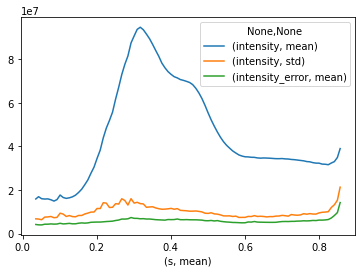

In [14]:
# divide into 100 equal sized bins
s_bins = pd.cut(df['s'],100)

# compute statistics in each bin
df_isoavg = df.groupby(s_bins).agg({
    's':'mean',
    'intensity':['mean','std'],
    'intensity_error':'mean'})

# plot statistics vs. s
df_isoavg.set_index(('s','mean')).plot();